<style>
td, th {
   border: none!important;
}
</style>

||||
|---|---|---|
|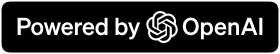|<img src="media/plusSign.jpg" alt="drawing" width="50"/>|<img src="media/PSLogo.png" alt="drawing" width="75"/>|


# How to call functions with chat models

Function Calling is a new way to more reliably connect GPT's capabilities with external tools and APIs.
Some of the benefits of using function calling include:

1. **Modular Code:** Enhances code organization and reusability.
2. **New Capabilities:** Expands AI's inherent functionality range.
3. **Performance Optimizations:** Specialized functions boost efficiency.
4. **Interactive Conversations:** Enables dynamic, real-time dialogues.
5. **Simplicity and Ease:** Maintains clean, manageable AI code.
6. **Better Error Handling:** Isolates and addresses issues effectively.
7. **Adaptability:** Facilitates updates without system disruption.


This notebook covers how to use the Chat Completions API in combination with external functions to extend the capabilities of GPT models.

`functions` is an optional parameter in the Chat Completion API which can be used to provide function specifications. The purpose of this is to enable models to generate function arguments which adhere to the provided specifications. Note that the API will not actually execute any function calls. It is up to developers to execute function calls using model outputs.

If the `functions` parameter is provided then by default the model will decide when it is appropriate to use one of the functions. The API can be forced to use a specific function by setting the `function_call` parameter to `{"name": "<insert-function-name>"}`. The API can also be forced to not use any function by setting the `function_call` parameter to `"none"`. If a function is used, the output will contain `"finish_reason": "function_call"` in the response, as well as a `function_call` object that has the name of the function and the generated function arguments.

## Overview

### Getting Started
#### You can Get this Notebooks here:
`GitHub Repo` [https://github.com/dfinke/PowerShellAI.Functions](https://github.com/dfinke/PowerShellAI.Functions)

## Set Your OpenAI Key

Don't have one!? Get one [https://platform.openai.com/account/api-keys](https://platform.openai.com/account/api-keys).

In [ ]:
$env:OpenAIKey = 'sk-xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx'

## Install PowerShellAI

In [4]:
$module = 'PowerShellAI'
$moduleExists = gmo -list $module 
if($null -eq $moduleExists) {
    Install-Module -Name $module -Force
} else {
    Write-Host "Module $module already installed" -ForegroundColor Orange
}

Import-Module PowerShellAI -Force

Module PowerShellAI already installed


### Here is the PowerShell code to get the weather 

https://github.com/chubin/wttr.in is the REST API to be called

In [13]:
function Get-CurrentWeather {
    <#
        .FunctionDescription
            Gets the current weather for a location
        .ParameterDescription location
            The location to get the weather for
        .ParameterDescription unit
            The unit to get the weather in
    #>
    param (
        [string]$location,
        [ValidateSet('celsius', 'fahrenheit')]
        [string]$unit
    )
    
    $paramUnit ="m"
    if($unit -eq "fahrenheit") {
        $paramUnit = "u"
    }

    Write-Host "Getting the weather for $location in $unit"
    Invoke-RestMethod "https://wttr.in/$($location)?format=4&$paramUnit"
}

In [6]:
Get-CurrentWeather NYC fahrenheit

Getting the weather for NYC in fahrenheit
NYC: ☀️   🌡️+53°F 🌬️↓2mph



### OpenAI Function Spec
Let's use the metadata from the PowerShell function Get-CurrentWeather to create the OpenAI function spec.

In [14]:
$functions = ConvertFrom-FunctionDefinition (Get-Command Get-CurrentWeather)
$functions | ConvertTo-Json -Depth 10

{
  "name": "Get-CurrentWeather",
  "description": "Gets the current weather for a location",
  "parameters": {
    "type": "object",
    "properties": {
      "location": {
        "type": "string",
        "description": "The location to get the weather for"
      },
      "unit": {
        "type": "string",
        "description": "The unit to get the weather in",
        "enum": [
          "celsius",
          "fahrenheit"
        ]
      }
    },
    "required": [
      "location",
      "unit"
    ]
  }
}


### Natural Language for Weather

Straight text. This is a GPT prompt. Needs to be in this format to work with the OpenAI REST API.

In [15]:
$q = 'what is the weather like today, in Greenland?'
# $q = 'what is the weather like today, in Greenland, farenheight?'

$messages = @(
    New-ChatMessageTemplate user $q
)

$messages


role content
---- -------
user what is the weather like today, in Greenland?



### Call GPT

Now you pass in the message and OpenAI function spec and get back the response.

In [16]:
$chatResponse = Get-ChatCompletion $messages -functions $functions
$chatResponse


id      : chatcmpl-8LJTeOGs3BQKdBVXEvcvFSVu7OfXh
object  : chat.completion
created : 1700090450
model   : gpt-3.5-turbo-16k-0613
choices : {@{index=0; message=; finish_reason=function_call}}
usage   : @{prompt_tokens=88; completion_tokens=26; total_tokens=114}




### Here's the GPT Response

Key parts: `finish_reason` and `function_call`

Inspecting the `finish_reason`, if it is `function_call`, then we know that the GPT has generated a function call.
Now you can use the `function_call` to call the function.
In this case `Get-CurrentWeather`

In [17]:
$chatResponse.choices[0] | ConvertTo-Json -Depth 10

{
  "index": 0,
  "message": {
    "role": "assistant",
    "content": null,
    "function_call": {
      "name": "Get-CurrentWeather",
      "arguments": "{\n  \"location\": \"Greenland\",\n  \"unit\": \"celsius\"\n}"
    }
  },
  "finish_reason": "function_call"
}


### The Integration of the Chat Models with the PowerShell Functions

The following code is the integration of the chat models with the PowerShell functions.

If the `finish_reason` is `function_call` you can grab the function name and arguments from the message.
The `arguments` are JSON. With some PowerShell magic you can convert the JSON to a hashtable.

Now you have the function name and the arguments. using the call operator `&` you can call the function and splat the arguments.

In [18]:
$target = $chatResponse.choices[0]

if($target.'finish_reason' -eq 'function_call') {
    $functionName = $target.message.'function_call'.name
    $arguments = $target.message.'function_call'.arguments
    $splatParam = $arguments | ConvertFrom-Json -AsHashtable

    & $functionName @splatParam
}

Getting the weather for Greenland in celsius
Greenland: ☀️   🌡️-37°C 🌬️→31km/h



### The End

That's it! You have a PowerShell function `Get-CurrentWeather` and can use it with Natural Language by integration PowerShell and ChatGPT.

This is a very simple example, but you can use it to build more complex functions and integrate them with ChatGPT.

What are you going to add Natural Language to!?

## All the Code

This is all the individual code snippets from the notebook, wrapped in the function `Invoke-AskWeather`.

In [19]:
function Get-CurrentWeather {
    <#
        .FunctionDescription
            Gets the current weather for a location
        .ParameterDescription location
            The location to get the weather for
        .ParameterDescription format
            The format to get the weather in
    #>
    param (
        [string]$location,
        [ValidateSet('celsius', 'fahrenheit')]
        [string]$unit
    )

    $paramUnit = "m"
    if ($unit -eq "fahrenheit") {
        $paramUnit = "u"
    }

    Write-Host "Getting the weather for $location in $unit"
    Invoke-RestMethod "https://wttr.in/$($location)?format=4&$paramUnit"
}

function Invoke-AskWeather {
        param(
        [Parameter(Mandatory)]
        $q
    )

    $functions = ConvertFrom-FunctionDefinition (Get-Command Get-CurrentWeather)

    $messages = @(
        New-ChatMessageTemplate user $q
    )

    $chatResponse = Get-ChatCompletion $messages -functions $functions
    $target = $chatResponse.choices[0]

    if ($target.'finish_reason' -eq 'function_call') {
        $functionName = $target.message.'function_call'.name
        $arguments = $target.message.'function_call'.arguments
        $splatParam = $arguments | ConvertFrom-Json -AsHashtable

        & $functionName @splatParam
    }
}

In [20]:
Invoke-AskWeather 'weather in nyc'


Getting the weather for New York City in celsius
New York City: ☀️   🌡️+12°C 🌬️↓4km/h



In [21]:
# Notice the misspelling. GPT will correct it.
Invoke-AskWeather 'What is the weather in halfax? not celcius'

Getting the weather for Halifax in fahrenheit
Halifax: ⛅️  🌡️+45°F 🌬️←4mph

